In [1]:
!pip install gymnasium  
!pip install tensorflow  
!pip install numpy       
!pip install matplotlib
!pip install gradio
!pip install keyboard

In [2]:
# Importing the necessary libraries
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
print("All libraries imported successfully!")

print("Gymnasium version:", gym.__version__)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


All libraries imported successfully!
Gymnasium version: 1.0.0
TensorFlow version: 2.18.0
NumPy version: 1.26.4


In [3]:
try:
    env = gym.make('CarRacing-v3', render_mode='rgb_array')
    obs, info = env.reset()
    print("Environment initialized successfully with observation shape:", obs.shape)
    env.close()
except Exception as e:
    print(f"Error initializing the environment: {e}")

Environment initialized successfully with observation shape: (96, 96, 3)


In [4]:
# KL Divergence Regularizer
class KLRegularizer(tf.keras.layers.Layer):
    def __init__(self, kl_tolerance, z_size):
        super(KLRegularizer, self).__init__()
        self.kl_tolerance = kl_tolerance
        self.z_size = z_size

    def call(self, inputs):
        mu, logvar = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
        return tf.maximum(kl_loss, self.kl_tolerance)


In [5]:
# VAE model definition
class ConvVAE(object):
    def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5):
        self.z_size = z_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.kl_tolerance = kl_tolerance
        self.build_vae_model()

    def build_vae_model(self):
        # Encoder
        self.inputs = tf.keras.Input(shape=(64, 64, 3))
        h = Conv2D(32, 4, strides=2, activation='relu')(self.inputs)
        h = Conv2D(64, 4, strides=2, activation='relu')(h)
        h = Conv2D(128, 4, strides=2, activation='relu')(h)
        h = Conv2D(256, 4, strides=2, activation='relu')(h)
        h = Flatten()(h)
        self.mu = Dense(self.z_size)(h)
        self.logvar = Dense(self.z_size)(h)
        self.z = self.mu + tf.keras.layers.Lambda(lambda x: tf.random.normal(tf.shape(x)) * tf.exp(self.logvar / 2))(self.logvar)

        # Decoder
        h = Dense(1024)(self.z)
        h = Reshape((1, 1, 1024))(h)
        h = Conv2DTranspose(128, 5, strides=2, activation='relu')(h)
        h = Conv2DTranspose(64, 5, strides=2, activation='relu')(h)
        h = Conv2DTranspose(32, 6, strides=2, activation='relu')(h)
        self.outputs = Conv2DTranspose(3, 6, strides=2, activation='sigmoid')(h)

        # Model creation
        self.vae = tf.keras.Model(self.inputs, self.outputs)
        self.vae.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate), loss='mse')


In [6]:
class MDNRNN:
    def __init__(self, hps):
        self.hps = hps
        self.build_rnn_model()

    def build_rnn_model(self):
        # Define LSTM model using keras.layers
        self.inputs = tf.keras.Input(shape=(self.hps.max_seq_len, self.hps.input_seq_width))
        lstm_layer = LSTM(self.hps.rnn_size, return_sequences=True, name='RNN_Layer')(self.inputs)
        self.outputs = Dense(self.hps.output_seq_width * self.hps.num_mixture * 3, name='output')(lstm_layer)
        self.rnn = tf.keras.Model(self.inputs, self.outputs)

    def compile_model(self):
        # Compile the model using the mdn_loss method within the class
        self.rnn.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.hps.learning_rate), 
            loss=self.mdn_loss
        )

    def mdn_loss(self, y_true, y_pred):
        """MDN Loss Function encapsulated within the class."""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Split y_pred into its components (logmix, mean, logstd)
        logmix, mean, logstd = tf.split(y_pred, num_or_size_splits=3, axis=-1)

        # Compute the loss components
        num_mixtures = self.hps.num_mixture
        mean = tf.reshape(mean, (-1, tf.shape(mean)[1], tf.shape(mean)[2] // num_mixtures, num_mixtures))
        logstd = tf.reshape(logstd, (-1, tf.shape(logstd)[1], tf.shape(logstd)[2] // num_mixtures, num_mixtures))

        # Expand y_true to match the number of mixtures
        y_true = tf.expand_dims(y_true, axis=-1)

        logmix = tf.reshape(logmix, (-1, tf.shape(logmix)[1], tf.shape(mean)[2], num_mixtures))
        logmix = logmix - tf.reduce_logsumexp(logmix, axis=-1, keepdims=True)

        logsqrtTwoPI = tf.cast(np.log(np.sqrt(2.0 * np.pi)), tf.float32)
        log_prob = -0.5 * tf.square((y_true - mean) / tf.exp(logstd)) - logstd - logsqrtTwoPI
        v = logmix + log_prob

        # Return negative log-likelihood
        return -tf.reduce_mean(tf.reduce_logsumexp(v, axis=-1))

    def manual_train(self, x_train, y_train, epochs, batch_size):
        """Manual training without tf.data.Dataset."""
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.hps.learning_rate)
        dataset_size = x_train.shape[0]
        steps_per_epoch = dataset_size // batch_size

        for epoch in range(epochs):
            tf.print(f"Epoch {epoch + 1}/{epochs}")

            # Shuffle the data
            indices = np.arange(dataset_size)
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            for step in range(steps_per_epoch):
                start_idx = step * batch_size
                end_idx = start_idx + batch_size
                x_batch = x_train[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx]

                with tf.GradientTape() as tape:
                    predictions = self.rnn(x_batch, training=True)
                    loss = self.mdn_loss(y_batch, predictions)

                gradients = tape.gradient(loss, self.rnn.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.rnn.trainable_variables))

                if step % 10 == 0:
                    tf.print(f"Step {step}, Loss: ", loss)


In [7]:
# Define Hyperparameters
class HParams:
    def __init__(self):
        self.max_seq_len = 100
        self.input_seq_width = 160
        self.output_seq_width = 160
        self.rnn_size = 64
        self.num_mixture = 5
        self.learning_rate = 0.001
        self.batch_size = 16

# Set up hyperparameters
hps = HParams()
rnn_model = MDNRNN(hps)
rnn_model.compile_model()

# Example data for training
x_train_rnn = np.random.rand(100, hps.max_seq_len, hps.input_seq_width).astype(np.float32)
y_train_rnn = np.random.rand(100, hps.max_seq_len, hps.output_seq_width).astype(np.float32)

# Train the RNN model
rnn_model.manual_train(x_train_rnn, y_train_rnn, epochs=10, batch_size=hps.batch_size)


Epoch 1/10
Step 0, Loss:  1.08631325
Epoch 2/10
Step 0, Loss:  0.865049839
Epoch 3/10
Step 0, Loss:  0.496400565
Epoch 4/10
Step 0, Loss:  0.270104378
Epoch 5/10
Step 0, Loss:  0.229145572
Epoch 6/10
Step 0, Loss:  0.190373346
Epoch 7/10
Step 0, Loss:  0.175270244
Epoch 8/10
Step 0, Loss:  0.153543055
Epoch 9/10
Step 0, Loss:  0.133560613
Epoch 10/10
Step 0, Loss:  0.116792679


Environment initialized successfully. Observation shape: (96, 96, 3)
Environment reset successful. Observation shape: (96, 96, 3)


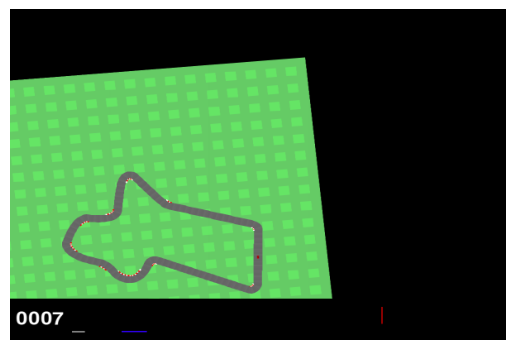

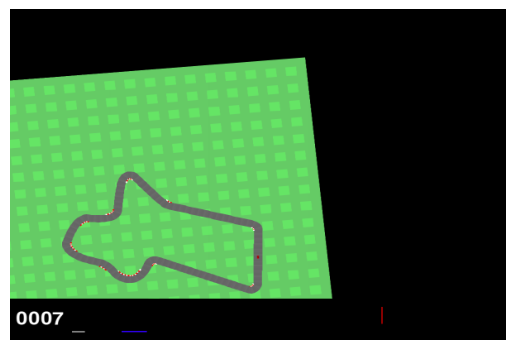

In [8]:
# Create the gym environment and render the initial frame
env = gym.make('CarRacing-v3', render_mode='rgb_array')
obs, _ = env.reset()
print("Environment initialized successfully. Observation shape:", obs.shape)
env.close()

# Reset environment and fetch the first observation
obs, info = env.reset()
print("Environment reset successful. Observation shape:", obs.shape)

# Example of deriving an action and stepping through the environment
action = np.array([0.0, 1.0, 0.0])  # Example action: no steering, full gas, no brake
obs, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

# Render the environment visually (instead of rgb_array)
frame = env.render()
plt.imshow(frame)
plt.axis('off')
from IPython.display import display
display(plt.gcf())


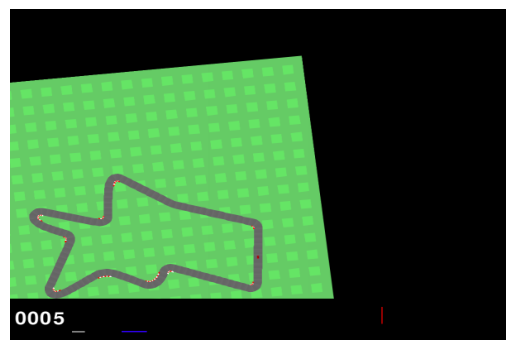

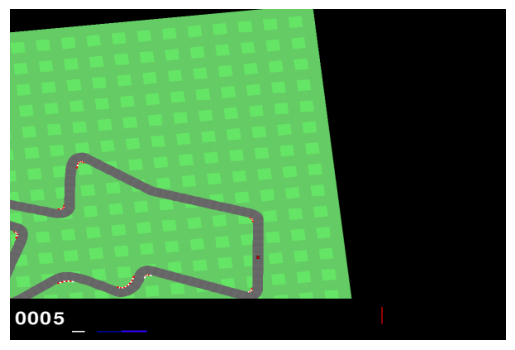

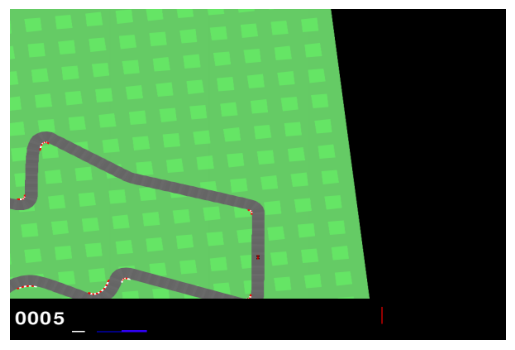

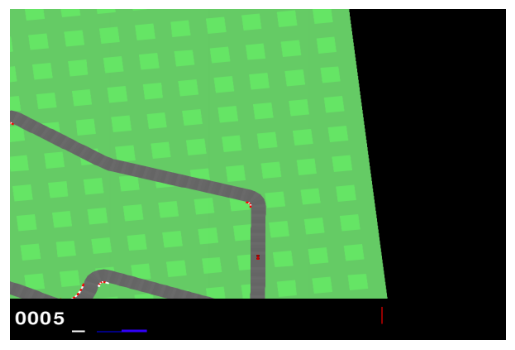

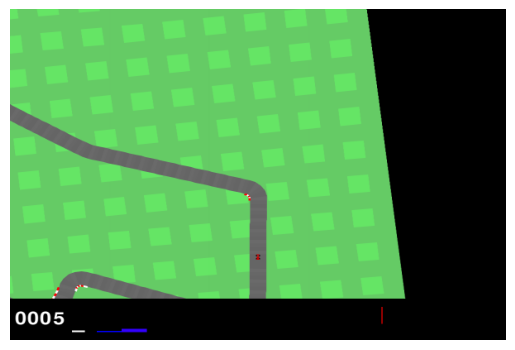

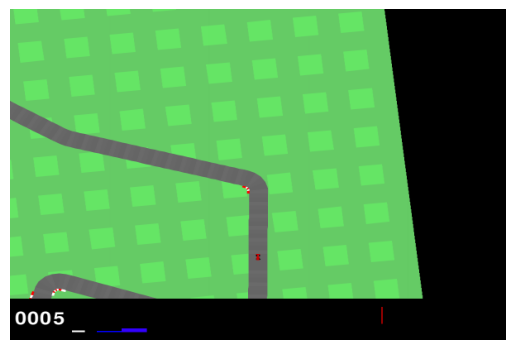

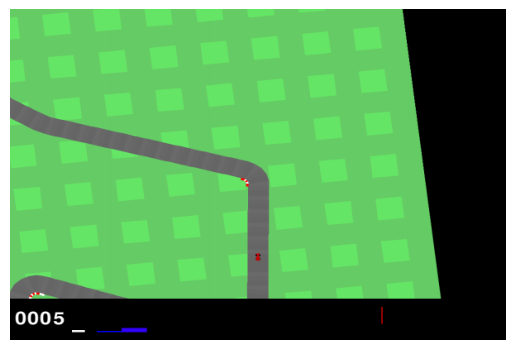

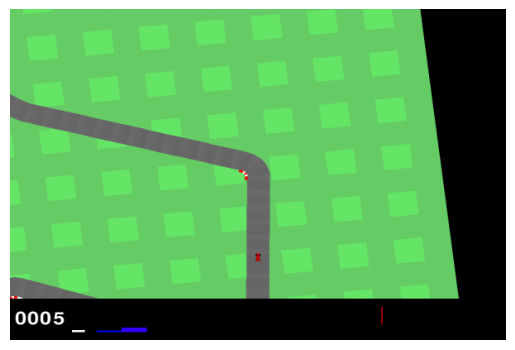

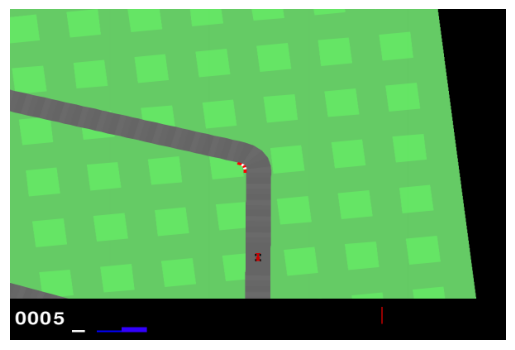

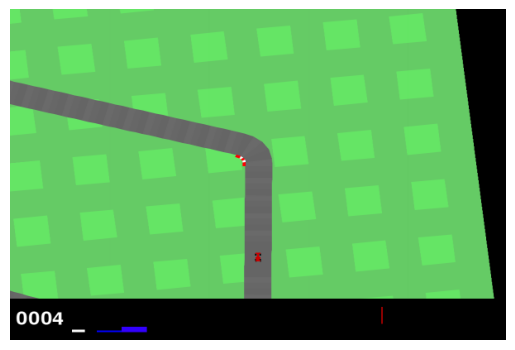

In [9]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

# Use the latest version of CarRacing (v3)
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs, _ = env.reset()

# Render 10 frames
for _ in range(10):
    action = np.array([0.0, 1.0, 0.0], dtype=np.float32)  # Full gas, no steering, no brake
    obs, reward, terminated, truncated, _ = env.step(action)
    frame = env.render()  # Directly get the frame

    # Display the frame
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

    if terminated or truncated:
        break

env.close()


In [10]:
import gradio as gr
import gymnasium as gym
import numpy as np
from PIL import Image
import keyboard

# AI Play Stream Function (Generator)
def ai_play_stream(num_steps):
    try:
        env = gym.make("CarRacing-v3", render_mode="rgb_array")
        obs, _ = env.reset()
        total_reward = 0

        for _ in range(num_steps):
            # AI Action: Full throttle, no steering
            action = np.array([0.0, 1.0, 0.0], dtype=np.float32)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            # Render the frame
            frame = env.render()
            yield total_reward, frame  # Yield total reward and frame to Gradio

            if terminated or truncated:
                break

        env.close()

    except Exception as e:
        yield f"Error: {e}", None


# Human Play Live Stream Function
def human_play_live(num_steps):
    try:
        env = gym.make("CarRacing-v3", render_mode="rgb_array")
        obs, _ = env.reset()
        total_reward = 0

        for _ in range(num_steps):
            # Fetch keypresses for WASD controls
            steering = -1.0 if keyboard.is_pressed("a") else (1.0 if keyboard.is_pressed("d") else 0.0)
            gas = 1.0 if keyboard.is_pressed("w") else 0.0
            brake = 1.0 if keyboard.is_pressed("s") else 0.0
            action = np.array([steering, gas, brake], dtype=np.float32)

            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            frame = env.render()

            yield total_reward, frame  # Stream total reward and frame

            if terminated or truncated:
                break

        env.close()
    except Exception as e:
        yield f"Error: {e}", None


# Build Gradio Interface
def build_interface():
    with gr.Blocks() as interface:
        gr.Markdown("# Do Neural Nets Dream of Fast Cars")
        gr.Markdown("Watch the AI play CarRacing-v3, then play yourself to try and beat its score.")

        # AI Play Section
        with gr.Row():
            num_steps = gr.Slider(10, 500, value=200, step=10, label="Number of Steps")
            ai_total_reward = gr.Number(label="AI Total Reward")
            ai_live_frame = gr.Image(label="AI Live Gameplay")
            ai_play_btn = gr.Button("Let AI Play")

            # Connect the AI Play button to the streaming generator
            ai_play_btn.click(
                ai_play_stream,
                inputs=[num_steps],
                outputs=[ai_total_reward, ai_live_frame],
                show_progress=True,  # Optional: Show a progress bar
            )

        # Human Play Section
        with gr.Row():
            gr.Markdown("### Human Play: Use WASD Keys to Control the Car")
            num_steps_human = gr.Slider(10, 500, step=10, label="Number of Steps")
            human_total_reward = gr.Number(label="Your Total Reward")
            human_live_frame = gr.Image(label="Your Live Gameplay")
            human_play_btn = gr.Button("Play Live")

            human_play_btn.click(
                human_play_live, inputs=[num_steps_human], outputs=[human_total_reward, human_live_frame]
            )

    return interface


# Run the Interface
if __name__ == "__main__":
    build_interface().launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://98e6eaf66d12a69396.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
